In [1]:
import pandas as pd
import os

current_path = os.getcwd()

train_file = os.path.join(current_path, "data/train")  # 训练集文件夹
val_file = os.path.join(current_path, "data/val")  # 验证集文件夹

train_audio = os.path.join(train_file, "audio_train")  # 训练集音频文件夹
val_audio = os.path.join(val_file, "audio_val")  # 验证集音频文件夹

train_scale_file = os.path.join(train_file, "audio_scale_train.xlsx")  # 训练集音频标签文件
val_scale_file = os.path.join(val_file, "audio_scale_val.xlsx")  # 验证集音频标签文件

feature_file = os.path.join(current_path, "features")  # 特征文件夹

saved_model_file = os.path.join(current_path, "saved_model/best.pth")  # 保存模型文件

In [2]:
import opensmile

# 提取音频特征
def extract_audio_feature(input_file, feature_file, mode):
    wav_vad_files = os.listdir(input_file)

    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    if mode == "train":
        eGeMAPSv02_Functionals_feature_path = os.path.join(feature_file, "eGeMAPSv02_Functionals_train_features.csv")
    elif mode == "val":
        eGeMAPSv02_Functionals_feature_path = os.path.join(feature_file, "eGeMAPSv02_Functionals_val_features.csv")


    count = 0
    for wav_vad in wav_vad_files:
        wav_vad_path = os.path.join(input_file, wav_vad)
        # print(wav_vad_path)
        feature = smile.process_file(wav_vad_path)
        
        if count == 0:
            feature.to_csv(eGeMAPSv02_Functionals_feature_path, mode='a', index=False)
        else:
            feature.to_csv(eGeMAPSv02_Functionals_feature_path, mode='a', header=False, index=False)
        count += 1

# extract_audio_feature(input_file=train_audio, feature_file=feature_file, mode="train")
# extract_audio_feature(input_file=val_audio, feature_file=feature_file, mode="val")

{'ComParE_2016': <FeatureSet.ComParE_2016: 'compare/ComParE_2016'>,  
'GeMAPS': <FeatureSet.GeMAPS: 'gemaps/v01a/GeMAPSv01a'>,  
'GeMAPSv01a': <FeatureSet.GeMAPS: 'gemaps/v01a/GeMAPSv01a'>,  
'GeMAPSv01b': <FeatureSet.GeMAPSv01b: 'gemaps/v01b/GeMAPSv01b'>,  
'eGeMAPS': <FeatureSet.eGeMAPS: 'egemaps/v01a/eGeMAPSv01a'>,  
'eGeMAPSv01a': <FeatureSet.eGeMAPS: 'egemaps/v01a/eGeMAPSv01a'>,  
'eGeMAPSv01b': <FeatureSet.eGeMAPSv01b: 'egemaps/v01b/eGeMAPSv01b'>,  
'eGeMAPSv02': <FeatureSet.eGeMAPSv02: 'egemaps/v02/eGeMAPSv02'>,  
'emobase': <FeatureSet.emobase: 'emobase/emobase'>} 

['ComParE_2016', 
'GeMAPS', 
'GeMAPSv01b', 
'__class__', '__doc__', '__members__', '__module__', 
'eGeMAPS', 
'eGeMAPSv01b', 
'eGeMAPSv02', 
'emobase']

{'LowLevelDescriptors': <FeatureLevel.LowLevelDescriptors: 'lld'>, 
'LowLevelDescriptors_Deltas': <FeatureLevel.LowLevelDescriptors_Deltas: 'lld_de'>, 
'Functionals': <FeatureLevel.Functionals: 'func'>}

['Functionals', 'LowLevelDescriptors', 'LowLevelDescriptors_Deltas', '__class__', '__doc__', '__members__', '__module__']

In [3]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, feature_file, label_file, scaler=None, transform=None):
        self.feature_file = feature_file
        self.label_file = label_file
        self.scaler = scaler
        self.labels = self.load_annotations()
        self.features = self.load_features()
        self.transform = transform

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        if self.transform:
            feature = self.transform(feature)
        return feature, label

    def load_annotations(self):
        df = pd.read_excel(self.label_file)

        # 提取特定的列，比如列名为 'column_name'
        column1 = df['量表完成时间']
        column2 = df['联系电话']
        column3 = df['抑郁得分']

        # 将两列数据拼接在一起
        concatenated_columns = pd.concat([column1, column2, column3], axis=1)

        audio_name = []
        labels = []
        for index, row in concatenated_columns.iterrows():
            audio_name.append(str(row['联系电话']) + '_' + row['量表完成时间'].replace('-', '_') + '.amr')
            labels.append(row['抑郁得分'])
        return labels
    
    def load_features(self):
        # 读取 CSV 文件
        df = pd.read_csv(self.feature_file)
        scaled_features = self.scaler.transform(df)  # 对数据进行标准化

        # 将每一行作为一个列表
        rows_as_lists = scaled_features.tolist()  #scledr之后

        return rows_as_lists


In [4]:
from sklearn.preprocessing import StandardScaler

features = pd.read_csv(os.path.join(feature_file, "eGeMAPSv02_Functionals_train_features.csv"))

scaler = StandardScaler()
scaler.fit(features)

StandardScaler()

In [5]:
train_dataset = AudioDataset(feature_file=os.path.join(feature_file, "eGeMAPSv02_Functionals_train_features.csv"), 
                             label_file=train_scale_file, 
                             scaler=scaler)
val_dataset = AudioDataset(feature_file=os.path.join(feature_file, "eGeMAPSv02_Functionals_val_features.csv"), 
                           label_file=val_scale_file, 
                           scaler=scaler)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

In [6]:
len(train_loader), len(val_loader)

(23, 8)

In [7]:
import torch

for inputs, labels in train_loader:
    inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
    print('Feature is: {}'.format(inputs))
    print('Label is: {}'.format(labels))
    break

Feature is: tensor([[-8.2022e-01,  7.7323e-01, -7.6516e-01, -8.9550e-01, -8.6465e-01,
         -4.4175e-01, -1.2266e+00, -1.2374e+00, -7.8470e-01, -8.5281e-01,
         -1.4151e-01, -1.3948e+00,  5.4435e-01,  4.9462e-02, -2.5420e-01,
         -4.9436e-01, -5.7362e-01, -6.8793e-01, -4.8331e-01, -4.2074e-01,
         -2.4992e-01, -9.1712e-01,  7.4826e-01, -5.2309e-01, -1.3584e-01,
          1.4069e-01,  9.7889e-01, -2.3361e-01,  2.2907e-01, -1.4823e-01,
         -7.8956e-01, -1.0334e+00, -7.1873e-01, -3.0661e-01, -6.9427e-01,
         -3.0252e-02, -1.5316e+00, -1.6413e+00,  1.2599e-01, -2.9947e-01,
         -1.4506e+00, -1.7465e-01, -3.5334e-01, -4.2388e-01, -7.0126e-01,
          5.4960e-01, -1.2559e+00, -1.0581e-01,  8.9857e-01, -1.9642e-01,
         -9.6537e-01,  8.2504e-01, -1.0118e+00, -4.6418e-01,  3.3376e-01,
         -6.2767e-01, -9.8938e-01,  8.3593e-01, -5.6379e-01, -1.2960e-03,
          2.2989e-01, -3.4242e-01, -2.3538e-01, -7.4058e-02, -8.8118e-01,
          1.4686e-01, -2.2

In [8]:
dataloaders = {'train':train_loader,'valid':val_loader}

# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [9]:
import torch.nn as nn

class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.layer1 = nn.Linear(88, 88)
        self.layer2 = nn.Linear(88, 32)
        self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 32)
        self.layer5 = nn.Linear(32, 32)
        self.layer6 = nn.Linear(32, 1)
        # self.layer7 = nn.Linear(64, 64)
        # self.layer8 = nn.Linear(32, 1)

        self.softplus = nn.Softplus()
        # self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        # x = self.relu(x)
        x = self.softplus(x)
        x = self.layer2(x)
        # x = self.relu(x)
        x = self.softplus(x)
        x = self.layer3(x)
        # x = self.relu(x)
        x = self.softplus(x)
        x = self.layer4(x)
        # x = self.relu(x)
        x = self.softplus(x)
        x = self.layer5(x)
        # x = self.relu(x)
        x = self.softplus(x)
        x = self.layer6(x)
        # x = self.relu(x)
        # x = self.layer7(x)
        # x = self.softplus(x)
        # x = self.layer8(x)
        return x

# 实例化模型
model = ANNModel()

In [10]:
import torch.optim as optim

# 优化器设置
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
# optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)  # 0.001
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # 学习率每7个epoch衰减成原来的1/10
criterion = nn.MSELoss()

In [11]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, filename='best.pth'):
    since = time.time()
    best_mae = 99999
    model.to(device)

    val_mae_history = []
    train_mae_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    mae = nn.L1Loss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_mae_loss = 0.0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.float(), labels.float())
                    mae_loss = mae(outputs.float(), labels.float())
                    # _, preds = torch.max(outputs, 1)
                    # print(loss)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_mae_loss += mae_loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            mae_epoch_loss = running_mae_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} MAE: {:.4f}'.format(phase, epoch_loss, mae_epoch_loss))
            

            # 得到最好那次的模型
            if phase == 'valid' and mae_epoch_loss < best_mae:
                best_mae = mae_epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),  # 字典里key就是各层的名字，值就是训练好的权重
                  'best_mae': best_mae,
                  'optimizer' : optimizer.state_dict(),  # 优化器的状态信息
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_mae_history.append(mae_epoch_loss)
                valid_losses.append(epoch_loss)
                # scheduler.step(epoch_loss)  # 学习率衰减
            if phase == 'train':
                train_mae_history.append(mae_epoch_loss)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Mae: {:4f}'.format(best_mae))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_mae_history, train_mae_history, valid_losses, train_losses, LRs 

In [23]:
model_ft, val_mae_history, train_mae_history, valid_losses, train_losses, LRs  = train_model(model, dataloaders, criterion, optimizer, num_epochs=1000, filename=saved_model_file)

Epoch 0/999
----------
Time elapsed 0m 0s
train Loss: 12.4935 MAE: 2.6603
Time elapsed 0m 0s
valid Loss: 26.3464 MAE: 3.5045
Optimizer learning rate : 0.0010000

Epoch 1/999
----------


d:\miniconda3\envs\speech_Depression\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\miniconda3\envs\speech_Depression\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
d:\miniconda3\envs\speech_Depression\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the

Time elapsed 0m 0s
train Loss: 12.3125 MAE: 2.6459
Time elapsed 0m 0s
valid Loss: 26.5309 MAE: 3.5905
Optimizer learning rate : 0.0010000

Epoch 2/999
----------
Time elapsed 0m 0s
train Loss: 12.5575 MAE: 2.6924
Time elapsed 0m 0s
valid Loss: 26.3467 MAE: 3.5062
Optimizer learning rate : 0.0010000

Epoch 3/999
----------
Time elapsed 0m 0s
train Loss: 12.3288 MAE: 2.6520
Time elapsed 0m 0s
valid Loss: 26.3862 MAE: 3.5350
Optimizer learning rate : 0.0010000

Epoch 4/999
----------
Time elapsed 0m 1s
train Loss: 12.3432 MAE: 2.6544
Time elapsed 0m 1s
valid Loss: 26.6009 MAE: 3.6102
Optimizer learning rate : 0.0010000

Epoch 5/999
----------
Time elapsed 0m 1s
train Loss: 12.6116 MAE: 2.6695
Time elapsed 0m 1s
valid Loss: 26.4685 MAE: 3.5708
Optimizer learning rate : 0.0010000

Epoch 6/999
----------
Time elapsed 0m 1s
train Loss: 12.3690 MAE: 2.6337
Time elapsed 0m 1s
valid Loss: 26.3317 MAE: 3.4856
Optimizer learning rate : 0.0010000

Epoch 7/999
----------
Time elapsed 0m 1s
train Los

In [24]:
import matplotlib.pyplot as plt

def plot_curve(train_history, val_history):
    """
    绘制训练集和验证集曲线

    Parameters:
        train_history (list): 训练集每个 epoch 的 结果 列表
        val_history (list): 验证集每个 epoch 的 结果 列表

    Returns:
        None
    """
    epochs = range(1, len(train_history) + 1)
    
    # 绘制训练集和验证集的 结果 曲线
    plt.plot(epochs, train_history, label='Training Loss')
    plt.plot(epochs, val_history, label='Validation Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Waiting')
    plt.title('Training and Validation Results Curve over Epochs')
    plt.legend()
    plt.show()

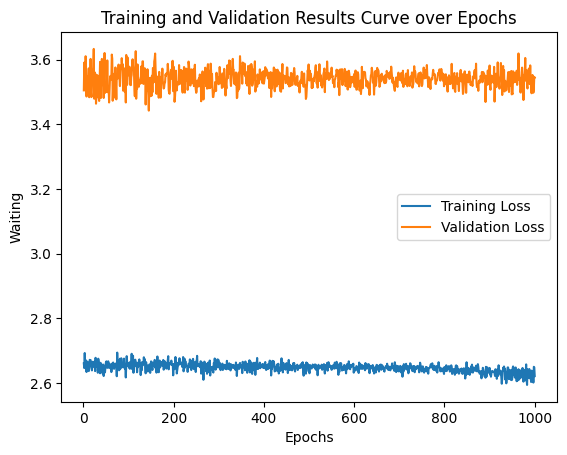

In [26]:
plot_curve(train_mae_history, val_mae_history)